# DM - Anomaly Detection

#### Axel ROUSSE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize'] = [15, 5]

# Set the style for better visualization
sns.set_theme(style="whitegrid")

In [3]:
df = pd.read_csv("data/dataset.csv")

In [6]:
df.sample(n=5).to_csv("dataset_sample.csv")

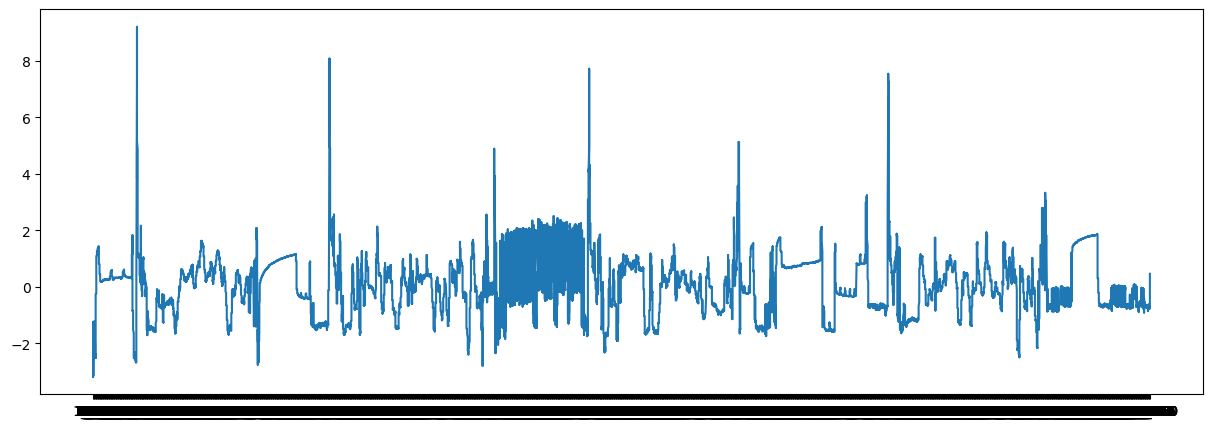

In [12]:
plt.plot(df['day_cycle_window'], df['p11'])

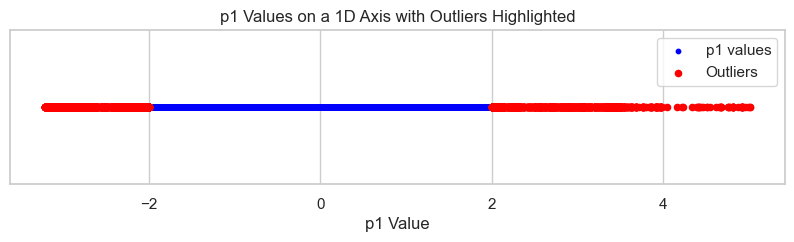

In [9]:
# Calculate mean and standard deviation for 'p1'
mean_p1 = df['p1'].mean()
std_p1 = df['p1'].std()

# Identify outliers (values beyond 2 standard deviations from the mean)
outlier_mask = (df['p1'] < mean_p1 - 2 * std_p1) | (df['p1'] > mean_p1 + 2 * std_p1)
outliers = df[outlier_mask]

# Plotting 'p1' values on a 1D axis (all points aligned at y=0) and marking outliers
plt.figure(figsize=(10, 2))

# Plot all values of 'p1' on a horizontal line (y=0)
plt.scatter(df['p1'], np.zeros_like(df['p1']), color='blue', label='p1 values', s=10)

# Highlight outliers in red
plt.scatter(outliers['p1'], np.zeros_like(outliers['p1']), color='red', label='Outliers', s=20)

# Adding labels and legend
plt.xlabel('p1 Value')
plt.yticks([])  # Hide y-axis ticks since all points are at y=0
plt.title('p1 Values on a 1D Axis with Outliers Highlighted')
plt.legend()

# Show plot
plt.show()


<Axes: xlabel='day_cycle_window'>

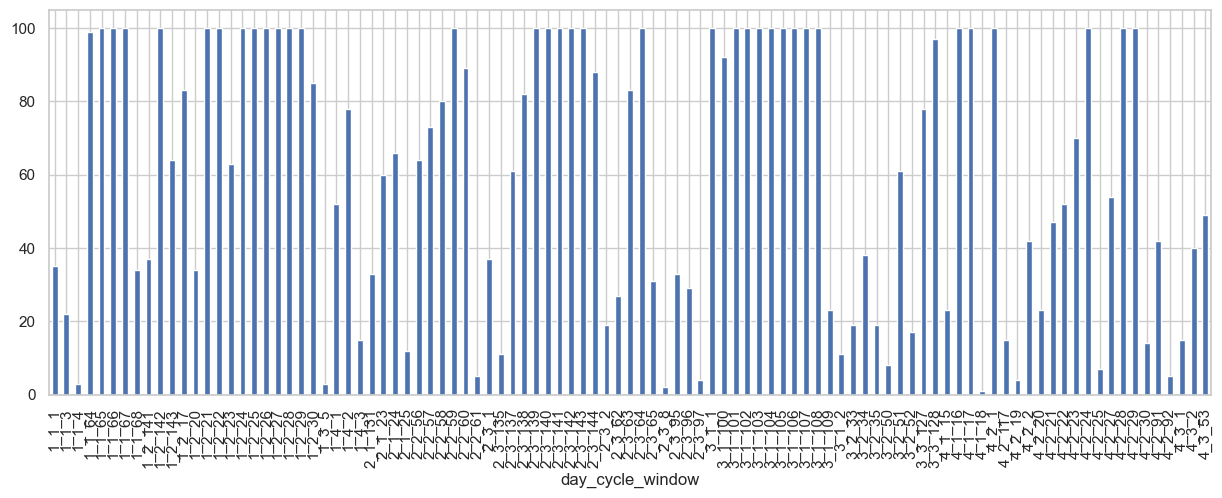

In [15]:
# Extract the 'day_cycle_window' values for the outliers
outlier_windows = outliers['day_cycle_window'].value_counts()

# Display the most frequent 'day_cycle_window' values among the outliers
outlier_windows.sort_index().plot(kind='bar')